In [1]:
import matplotlib.pyplot as plt
import numpy as np
from formula import Formula
from formula import crossover_formulas
import random
plt.style.use('seaborn-v0_8')

import scikits.bootstrap as bootstrap
import warnings
warnings.filterwarnings('ignore')

import scipy.stats # for finding statistical significance

import copy
import time

## Graphing Functions
`plot_mean_and_bootstrapped_ci_over_time`: Plots the mean, bootstrapped 95% C.I over generational time

`plot_mean_over_time`: Plots the means over generational time

In [2]:
def plot_mean_and_bootstrapped_ci_over_time(input_data = None, name = "change me",
                                            x_label = "change me", y_label="change me",
                                            y_limit = None, plot_bootstrap = True):
    """
    
    parameters: 
    input_data: (numpy array of shape (max_k, num_repitions)) solution metric to plot
    name: (string) name for legend
    x_label: (string) x axis label
    y_label: (string) y axis label
    
    returns:
    None
    """
    num_generations = input_data.shape[1]
    num_runs = input_data.shape[0]
    
    # Make plotting the bootstrap optional!
    if plot_bootstrap:
        # confidence interval values need to be calculated separately for each generation

        # So, find the confidence interval over all of the repetitions (:) at each generation,
        # using [:,generation] 
        CIs = np.array([bootstrap.ci(data=input_data[:, generation])
                        for generation in range(num_generations)])
        # Creating np.arrays through list conversion is still a bit cheeky,
        # but it works fine and allows for better indexing (: and ,)

        # Take every generation's (:) lows (0)
        ci_low = CIs[:,0]
        # And take every generation's (:) highs (1)
        ci_high = CIs[:,1]

        plt.fill_between(range(num_generations), ci_low, ci_high, alpha=0.4)
    
    plt.plot(np.mean(input_data, axis=0), label = name)
    
    # Plot annotations
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.ylim(y_limit)
    plt.legend()

## Evolutionary Algorithms
`basic_evolutionary_algorithm': basic algorithm with truncation selection 

In [3]:
def basic_evolutionary_algorithm(degree = 2, min_len=5, max_len=25,path = None, total_generations=100, num_parents=10, num_children = 10, num_elements_to_mutate=1, num_crossover=2, crossover=True):
    """
    :param degree:  
    :param min_len: 
    :param max_len: 
    :param path: 
    :param total_generations: 
    :param num_parents: 
    :param num_children: 
    :param num_elements_to_mutate: 
    :param num_crossover: 
    :param crossover: 
    :return: 
    """
    #init record keeping
    solution = None
    solution_fitness = -999999
    fitness_over_time = []
    solution_over_time = []
    diversity_over_time = []
    
    #init population
    Individuals = []
    for _ in range(num_parents):
        Individuals.append(Formula(min_len, max_len, degree, path))
    
    for i in range(total_generations):
        generation_fitnesses = []
        for ind in Individuals:
            generation_fitnesses.append(ind.eval_fitness()[0])
        fitness_over_time.append(np.max(generation_fitnesses))
        
        children = []
        while len(children) < num_children:
            parent_1, parent_2 = random.sample(Individuals, 2)
            child_1 = copy.deepcopy(parent_1)
            child_2 = copy.deepcopy(parent_2)
            #crossover
            if crossover:
                child_1.formula, child_2.formula = crossover_formulas(child_1, child_2, num_crossover)
            #mutation
            child_1.mutate_formula(num_elements_to_mutate)
            child_2.mutate_formula(num_elements_to_mutate)
            # add children to population
            children.append(child_1)
            if len(children) < num_children:
                children.append(child_2)
            Individuals.extend(children)
            Individuals.sort(key=lambda ind: ind.eval_fitness(), reverse=True)
            Individuals = Individuals[:num_parents]
            #update solutions over time
            solution_over_time.append(Individuals[-1].formula)
        solution = solution_over_time[-1]
        solution_fitness = fitness_over_time[-1]
    return fitness_over_time, solution_over_time, solution, solution_fitness
    
    


In [4]:
experiment_results = {}
solutions_results = {}

In [5]:
num_runs = 5
total_generations = 50
path = './data/quadratic_equation_full_details.csv'
degree = 2
min_len = 5
max_len = 25
num_elements_to_mutate = 1
num_parents = 10
num_children = 10
num_crossover = 2

# tournament_size = 20
# num_tournament_winners = 10

crossover = True


experiment = 'trial 1'

experiment_results[experiment] = np.zeros([num_runs, total_generations])
solutions_results[experiment] = {}

for run in range(num_runs):
    fitness, solution, _,_ = basic_evolutionary_algorithm(degree,
                                                                min_len,
                                                                max_len,
                                                                path,
                                                                total_generations,
                                                                num_parents,
                                                                num_children,
                                                                num_elements_to_mutate,
                                                                num_crossover,
                                                                crossover)
    experiment_results[experiment][run] = fitness
    solutions_results[experiment][run] = solution

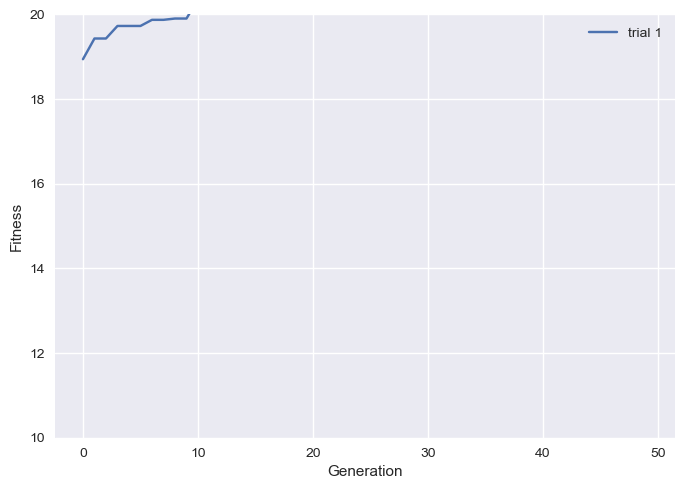

In [6]:
# plot fitness over time
# plotting
plt.figure(1, clear = True)
for experiment in experiment_results.keys():
    
    plot_mean_and_bootstrapped_ci_over_time(experiment_results[experiment],
                                            experiment,
                                            "Generation",
                                            "Fitness",
                                            [10,20],
                                            plot_bootstrap = False)
plt.show()

In [7]:
ran_form = Formula(min_len, max_len,degree,path)
ran_form.pretty_print_formula()
print(ran_form.evaluate_formula((1,1,1,_,_)))


 (((c-1) root 4)**3) 

0.015625


In [8]:
# actual quadratic formula:
# (-b (+|-) root((pow(b,2) - 4 * (a * c)),2)) / (2 * a)
q_form = ['a', 'b', 'c', 2, 3, 4, ('*',0,2), ('*',5,6), ('**',1,3), ('-',8,7), ('root',9,3), ('-', 10, 1), ('*',3,0),('/',11,12)]
quad = Formula(min_len, max_len, degree, path)
quad.formula = q_form
quad.length_of_constants = 6
quad.pretty_print_formula()
quad.eval_fitness()


 (((((b**2)-(4*(a*c))) root 2)-b)/(2*a)) 



(99.55036325893131, 0.004526891601241724)